Our preliminary tests showed, that Optigrid performed well on Data of November 2018. In this notebook we will explore a few other months and look for similarities and descrepancies in the results. We will use preprocessed data, where things like source stability and voltage breakdowns are indicated. Moreover, for now we will limit ourselfs to stable running sources, i.e. time periods with a low variance and a high current in the BCT25. We use the already preprocessed datasets.

### Module loading
We use the Python modules from the ionsrcopt package that will be loaded in the next cells.

In [13]:
# %load ../ionsrcopt/load_data.py
import pandas as pd
import numpy as np

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    if 'Timestamp (UTC_TIME)' in df.columns:
        print("Converting column \'{}\' to \'{}\'".format('Timestamp (UTC_TIME)', 'datetime'))
        df['Timestamp (UTC_TIME)'] = pd.to_datetime(df['Timestamp (UTC_TIME)']) 
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'IP.SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df

def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    if 'ITF.BCT15:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT15:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITF.BCT25:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT25:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITH.BCT41:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT41:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'ITL.BCT05:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['ITF.BCT05:CURRENT'].apply(lambda x: np.nan if x < 0 else x)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:OVEN1AQNP'].apply(lambda x: np.nan if x < 4.5 else x)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.SOLEXT.ACQUISITION:CURRENT'].apply(lambda x: np.nan if x < 1200 else x)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:BIASDISCAQNV'].apply(lambda x: np.nan if x == 0 else x)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.SAIREM2:FORWARDPOWER'].apply(lambda x: np.nan if x < 500 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x > 2.5 else x)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df['ITF.BCT25:CURRENT'] = df['IP.NSRCGEN:SOURCEHTAQNI'].apply(lambda x: np.nan if x < 0.5 else x)
    
    return df

In [15]:
# %load ../ionsrcopt/optigrid.py
""" Implementation of the Optigrid Algorithm described in "Optimal Grid-Clustering: Towards Breaking the Curse of
Dimensionality in High-Dimensional Clustering" by Hinneburg and Keim """

import pandas as pd
import numpy as np
import random
from sklearn.neighbors import KernelDensity

import itertools

import matplotlib.pyplot as plt

def estimate_distribution(data, cluster_indices, current_dimension, num_steps, bandwidth = 0.2, percentage_of_values=1, num_kde_samples=15000):
    sample_size = min(num_kde_samples, len(cluster_indices))
    sample = np.random.choice(cluster_indices, size=sample_size)
    datapoints = np.expand_dims(data[sample][:,current_dimension], -1)
    min_val = np.amin(datapoints)
    max_val = np.amax(datapoints)
    grid = np.linspace([min_val], [max_val], num_steps)
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth, atol=1E-6, rtol=1E-4).fit(datapoints)
    log_dens = kde.score_samples(grid)
    return grid, np.exp(log_dens) * percentage_of_values

def create_cuts_kde(data, cluster_indices, q, max_cut_score, noise_level, current_dimension, bandwidth=0.1, resolution=100, percentage_of_values=1, num_kde_samples=15000):
    grid, kde = estimate_distribution(data, cluster_indices, current_dimension, resolution, bandwidth=bandwidth, percentage_of_values=percentage_of_values, num_kde_samples=num_kde_samples) 
    
    #plt.plot(grid, kde)
    #plt.title("Current dimension: {}".format(current_dimension))
    #plt.show()
    
    kde = np.append(kde, 0)

    max=[]
    prev = 0
    current = kde[0]
    for bin in range(1, resolution+1): # Find all peaks that are above the noise level
        next = kde[bin] 
        if current > prev and current > next and current >= noise_level:
            max.append(bin-1)
        prev = current
        current = next
    
    if not max:
        return []

    max = [max[0]] + sorted(sorted(max[1:-1], key=lambda x: kde[x], reverse=True)[:q-1]) + [max[len(max)-1]] # and get the q-1 most important peaks between the leftest and rightest one.

    best_cuts = [] 
    for i in range(len(max)-1): # between these peaks search for the optimal cutting plane
        current_min = 1
        current_min_index = -1
        for j in range(max[i]+1, max[i+1]):
            if kde[j] < current_min:
                current_min = kde[j]
                current_min_index = j
        
        if current_min_index >= 0 and current_min < max_cut_score:
            best_cuts.append((grid[current_min_index], current_dimension, current_min)) # cutting plane format: (cutting coordinate, dimension in which we cut, density at minimum)
    return best_cuts

def create_cuts_histogram(data, cluster_indices, q, max_cut_score, noise_level, current_dimension, bins):
    hist, edges = np.histogram([data[ind][current_dimension] for ind in cluster_indices], density=True, bins=bins[current_dimension]) # First create the histogram of this dimension, 
    hist = np.append(hist, 0) # adding a zero density at the end to avoid the special case in the next loop, when searching for the maxima
    hist *= edges[1] - edges[0]
    
    max=[]
    prev = 0
    current = hist[0]
    for bin in range(len(bins[current_dimension])): # Find all peaks that are above the noise level
        next = hist[bin]
        if current > prev and current > next and current >= noise_level:
            max.append(bin-1)
        prev = current
        current = next
    
    if not max:
        return []

    max = [max[0]] + sorted(sorted(max[1:-1], key=lambda x: hist[x], reverse=True)[:q-1]) + [max[len(max)-1]] # and get the q-1 most important peaks between the leftest and rightest one.

    best_cuts = [] 
    for i in range(len(max)-1): # between these peaks search for the optimal cutting plane
        current_min = 1
        current_min_index = -1
        for j in range(max[i]+1, max[i+1]):
            if hist[j] < current_min:
                current_min = hist[j]
                current_min_index = j
        
        if current_min_index >= 0 and current_min < max_cut_score:
            best_cuts.append(((edges[current_min_index] + edges[current_min_index+1])/2, current_dimension, current_min)) # cutting plane format: (cutting coordinate, dimension in which we cut, density at minimum)
    return best_cuts

def fill_grid(data, cluster_indices, cuts):
    """ Partitions the grid based on the selected cuts and assignes each cell the corresponding data points (as indices)"""
    
    num_cuts = len(cuts)
    grid_index = np.zeros(len(cluster_indices))
    for i, cut in enumerate(cuts):
        cut_val = 2 ** i
        grid_index[np.take(np.take(data, cut[1], axis=1), cluster_indices) > cut[0]] += cut_val

    return [cluster_indices[grid_index==key] for key in range(2**num_cuts)]

def optigrid(data, d, q, max_cut_score, noise_level, cluster_indices=np.array([]), percentage_of_values=1):
    """ Main entry point of the algorithm. 

    Parameters:
        data (list of datapoints): The whole set of datapoints to be considered
        cluster_indices (list of int): The currently considered cluster. This is a list of indices with which the datapoints can be looked up in the data list. If None, then the whole set is considered as one cluster, typically whe the algorithm is started.
        d (int): The number of dimensions of the data
        q (int): number of cutting planes in each iteration
        max_cut_score (double): The maximum density (percentage) in the density estimation histograms that will be used when creating cutting planes. The lower the more different peaks will be grouped inside one cluster.
        noise_level (double): The background noise, everything below this threshold will not influence the cutting planes. As percentage of density.
    
    Returns:
        list of list of int: Each list in this list represents a cluster. The values are again indices which that the datapoints can be looked up in the data list.
    """
    
    if cluster_indices.size == 0:
        cluster_indices = np.array(range(0, len(data)))

    cuts = []
    for i in range(d): # First create all best cuts
        cuts += create_cuts_kde(data, cluster_indices, q, max_cut_score, noise_level, current_dimension=i, percentage_of_values=percentage_of_values)
    
    if not cuts:
        return [cluster_indices]
    
    cuts = sorted(cuts, key=lambda x: x[2]) # Sort the cuts based on the density at the minima

    grid = fill_grid(data, cluster_indices, cuts[:q]) # Fill the subgrid based on the cuts
    
    result = []
    for cluster in grid:
        if cluster.size==0:
            continue
        print("In current cluster: {}".format(percentage_of_values*len(cluster)/len(cluster_indices)))
        result += optigrid(data=data, d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, cluster_indices=cluster, percentage_of_values=percentage_of_values*len(cluster)/len(cluster_indices)) # Run Optigrid on every subgrid
    
    return result

def describe_cluster(cluster, columns):
    """ Generate descriptive statistics for a cluster

    Parameters:
        cluster (DataFrame): A dataframe, that contains density informations for every bin in the cluster
        columns (list of string): The names of the columns for which to generate statistics

    Returns: 
        Series: All statistics for the selected columns
    """
    
    mean = cluster.mean(axis = 0) 
    std = cluster.std(axis=0)
    quantiles = cluster.quantile([.25, .5, .75], axis=0)
    mins = cluster.min(axis=0)
    maxs = cluster.max(axis=0)
    
    count = cluster.count(axis=0)[0]
    
    result_columns = [[mean[i], std[i], std[i] / abs(mean[i]) * 100, mins[i], quantiles.iloc[0, i], quantiles.iloc[1, i], quantiles.iloc[2, i], maxs[i]] for i in range(len(columns))]
    result = list(itertools.chain(*result_columns)) + [count]
    
    value_columns = [[(col, 'mean'), (col, 'std'), (col, 'varC (%)'), (col, 'min'), (col, '25%'), (col, '50%'), (col, '75%'), (col, 'max')] for col in columns]
    index = list(itertools.chain(*value_columns)) + [('DENSITY', 'count')]
    
    return pd.Series(result, index=pd.MultiIndex.from_tuples(index))


def describe_clusters(df, columns):
    """ Summarize all clusters and sort them by density

    Parameters:
        df (DataFrame): A frame containing density and cluster information about every bin
        columns (list of string): The names of the columns for which to generate statistics
    
    Returns:
        DataFrame: Descriptive frame sorted by density
    """

    result = df[columns + ['OPTIGRID_CLUSTER']].groupby('OPTIGRID_CLUSTER').apply(describe_cluster, columns)
    num_of_datapoints = len(df.index)
    result[('DENSITY', 'percentage')] = result[('DENSITY', 'count')] / num_of_datapoints * 100
    return result.sort_values(('DENSITY', 'count'), ascending=0)

First, we need to specifiy all the columns we are interested in. There are three types: Parameters, these are the ones that will be clustered later on, Measurments and columns from preprocessing.

In [53]:
parameters = ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN', 'IP.NSRCGEN:SOURCEHTAQNI', 'IP.SAIREM2:FORWARDPOWER', 'IP.SOLCEN.ACQUISITION:CURRENT', 'IP.SOLEXT.ACQUISITION:CURRENT', 'IP.NSRCGEN:OVEN1AQNP', 'ITF.BCT25:CURRENT']
measurments = ['ITF.BCT25:CURRENT']
preprocessing = ['source_stable', 'is_breakdown']
columns_to_load = parameters + measurments + preprocessing

In [54]:
file = '../Data_Preprocessed/Nov2018.csv'
df_total = read_data_from_csv(file, columns_to_load, None)
df_total = convert_column_types(df_total)
df_total.dropna(inplace=True)

Loading data from csv file '../Data_Preprocessed/Nov2018.csv'
Started type conversion of columns...
Converting column 'IP.NSRCGEN:BIASDISCAQNV' to 'float32'
Converting column 'IP.NSRCGEN:GASSASAQN' to 'float32'
Converting column 'IP.NSRCGEN:SOURCEHTAQNI' to 'float32'
Converting column 'IP.SAIREM2:FORWARDPOWER' to 'float32'
Converting column 'IP.SOLCEN.ACQUISITION:CURRENT' to 'float32'
Converting column 'IP.SOLEXT.ACQUISITION:CURRENT' to 'float32'
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Converting column 'ITF.BCT25:CURRENT' to 'float32'
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist


In [55]:
df_total.head(0)

,IP.NSRCGEN:BIASDISCAQNV,IP.NSRCGEN:GASSASAQN,IP.NSRCGEN:OVEN1AQNP,IP.NSRCGEN:SOURCEHTAQNI,IP.SAIREM2:FORWARDPOWER,IP.SOLCEN.ACQUISITION:CURRENT,IP.SOLEXT.ACQUISITION:CURRENT,ITF.BCT25:CURRENT,source_stable,is_breakdown


Right now we only want to look at the source when it was stable and ignore all high voltage breakdowns.

In [56]:
source_stable = df_total['source_stable'] == 1
no_voltage_breakdown = df_total['is_breakdown'] == 0

df = df_total[source_stable & no_voltage_breakdown].copy()

Once the data is ready we can begin clustering. But first we standard scale it, so that all parameters have the same variance.

In [57]:
from sklearn import preprocessing
data = df[parameters].values
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

The selection of the parameters for optigrid can be done by looking of the densities of the normalized parameters. 

In [58]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,6)

def plot_cluster(data, cluster_indices, parameters, parameter_ranges, median, resolution, bandwidth, percentage_of_values, num_kde_samples):
    if isinstance(bandwidth, float):
        bandwidth = [bandwidth for i in range(len(parameters))]
    
    fig = plt.figure()
    
    for i, parameter in enumerate(parameters):
        grid, kde = estimate_distribution(data, cluster_indices, i, resolution, bandwidth=bandwidth[i], percentage_of_values=percentage_of_values, num_kde_samples=num_kde_samples)
        ax = plt.subplot('1{}{}'.format(len(parameters), i+1))
        ax.set_title("Density of {}".format(parameter))
        if parameter_ranges:
            ax.set_xlim(*parameter_ranges[i])
            #ax.set_ylim(*parameter_ranges[i][1])
            
        if median is not None:
            ax.axvline(x=median[i], color='red')
        
        ax.plot(grid, kde)
        
    plt.show()

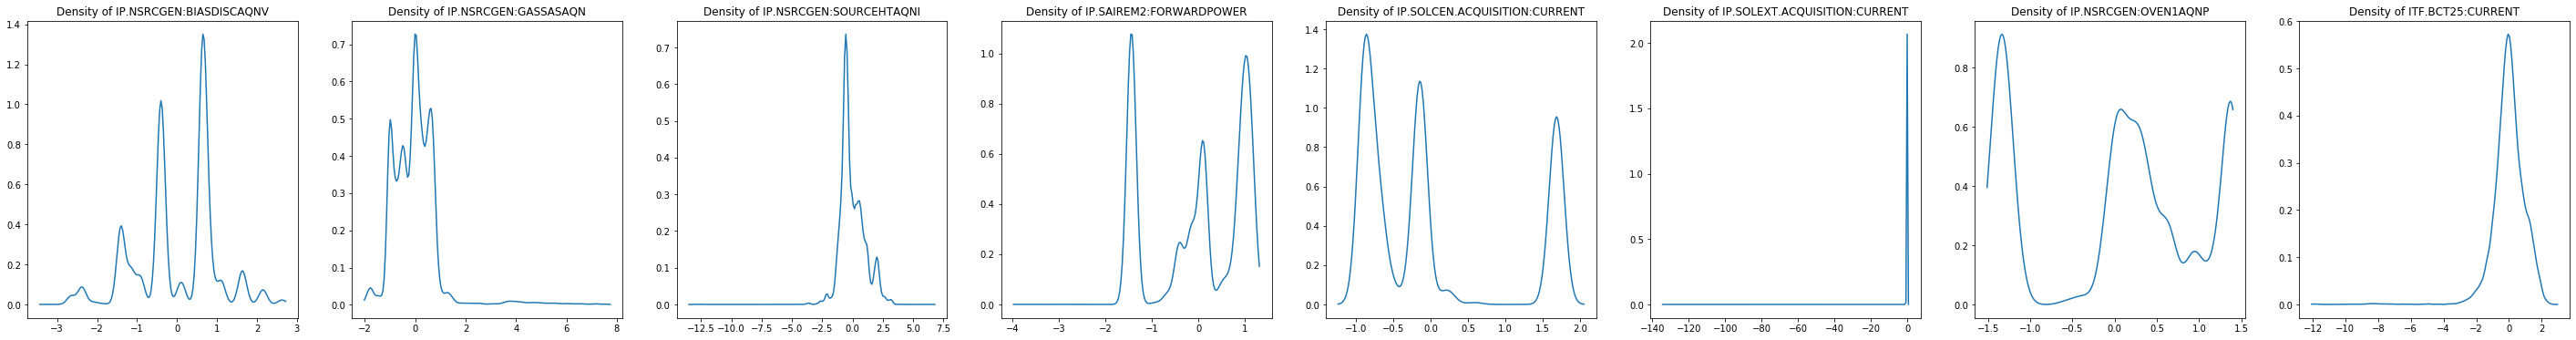

In [59]:
cluster_indices = np.array(range(0, len(data)))
resolution = 200
bandwidth = 0.1
num_kde_samples = 40000

plot_cluster(data, cluster_indices, parameters, parameter_ranges=None, median=None, resolution=resolution, bandwidth=bandwidth, percentage_of_values=1, num_kde_samples=num_kde_samples)

Based on these graphs we chose the noise level to be 0.1 and the max_cut_score, i.e. the maximum density where we still do a cut between two peaks, as 0.3

In [60]:
d=len(parameters)
q=1
max_cut_score = 0.3
noise_level = 0.1
opt = optigrid(data, d, q, max_cut_score, noise_level)

num_clusters = len(opt)
"Optigrid found {} clusters.".format(num_clusters)

In current cluster: 0.7593073536979515
In current cluster: 0.3071894124223924
In current cluster: 0.08594123113261681
In current cluster: 0.032711331351417385
In current cluster: 0.053229899781199436
In current cluster: 0.22124818128977555
In current cluster: 0.03417139006845384
In current cluster: 0.1870767912213217
In current cluster: 0.12981703682587395
In current cluster: 0.05725975439544775
In current cluster: 0.45211794127555915
In current cluster: 0.23656931090781871
In current cluster: 0.05399903372342277
In current cluster: 0.18257027718439595
In current cluster: 0.032672458155781556
In current cluster: 0.14989781902861438
In current cluster: 0.12379493093528908
In current cluster: 0.026102888093325286
In current cluster: 0.21554863036774044
In current cluster: 0.029605640685797217
In current cluster: 0.18594298968194323
In current cluster: 0.15086779781495618
In current cluster: 0.03306396676897104
In current cluster: 0.11780383104598514
In current cluster: 0.0723383893169054

'Optigrid found 16 clusters.'

In [61]:
labels = [None] * (len(data))
for cluster_ind, cluster in enumerate(opt):
    for el in cluster:
        labels[el] = cluster_ind
        
df['OPTIGRID_CLUSTER'] = labels
described = describe_clusters(df, parameters)

In [70]:
pd.set_option('display.max_columns', 500)
wanted_statistics = [[(param, 'mean'), (param, 'std')] for param in parameters]
wanted_statistics = [item for sublist in wanted_statistics for item in sublist] + [('DENSITY', 'percentage')]

num_of_clusters_to_print = 10
print("Sum of densities of printed clusters: {:.1f}%".format(described.head(n=num_of_clusters_to_print)[('DENSITY', 'percentage')].sum()))
described.head(n=num_of_clusters_to_print)[wanted_statistics].round(3)

Sum of densities of printed clusters: 81.2%


IP.NSRCGEN:BIASDISCAQNV         IP.NSRCGEN:GASSASAQN         \
                                    mean     std                 mean    std   
OPTIGRID_CLUSTER                                                               
15                              -237.647   0.781                5.192  0.019   
3                               -257.245   0.560                5.153  0.009   
7                               -262.378  11.300                5.186  0.010   
11                              -238.412   0.664                5.182  0.004   
4                               -238.676  10.762                5.211  0.103   
5                               -269.486   5.548                5.168  0.003   
1                               -275.841   0.522                5.205  0.019   
12                              -238.212   2.044                5.190  0.003   
14                              -234.210  10.708                5.198  0.003   
13                              -219.449   2.148                5.209  0.008   

                 IP.NSRCGEN:SOURCEHTAQNI        IP.SAIREM2:FORWARDPOWER  \
                                    mean    std                    mean   
OPTIGRID_CLUSTER                                                          
15                                 1.665  0.083                1011.252   
3                                  1.526  0.019                1606.025   
7                                  1.585  0.134                1947.587   
11                                 1.617  0.117                1942.846   
4                                  1.460  0.089                1516.932   
5                                  1.592  0.060                1385.968   
1                                  1.541  0.020                1508.240   
12                                 1.538  0.117                1934.894   
14                                 1.576  0.063                1011.585   
13                                 1.719  0.166                1994.245   

                          IP.SOLCEN.ACQUISITION:CURRENT         \
                      std                          mean    std   
OPTIGRID_CLUSTER                                                 
15                  6.838                       290.014  0.208   
3                   7.177                       240.010  0.000   
7                 104.231                       221.378  3.441   
11                 23.821                       220.031  0.639   
4                  86.541                       242.777  4.471   
5                  67.759                       225.007  0.381   
1                   7.894                       240.009  0.072   
12                 83.423                       221.889  7.902   
14                  6.972                       290.012  0.004   
13                 99.075                       240.089  4.167   

                 IP.SOLEXT.ACQUISITION:CURRENT         IP.NSRCGEN:OVEN1AQNP  \
                                          mean     std                 mean   
OPTIGRID_CLUSTER                                                              
15                                    1259.727   0.515               18.816   
3                                     1259.719   0.506                6.293   
7                                     1259.790   0.545               12.716   
11                                    1259.781   0.541               14.034   
4                                     1259.721   0.505                6.394   
5                                     1258.505  39.372               14.087   
1                                     1259.773   0.546                5.894   
12                                    1259.744   0.519               15.543   
14                                    1259.763   0.545               16.908   
13                                    1259.837   0.534               12.318   

                        ITF.BCT25:CURRENT           DENSITY  
                    std              mean    std pe

For visualizing the clusters we will plot the densities of the parameters. For comparability we will use explicit ranges for the x-axis per parameter. Those ranges should be chosen beforehand by an expert to validate or falsify his intuition.

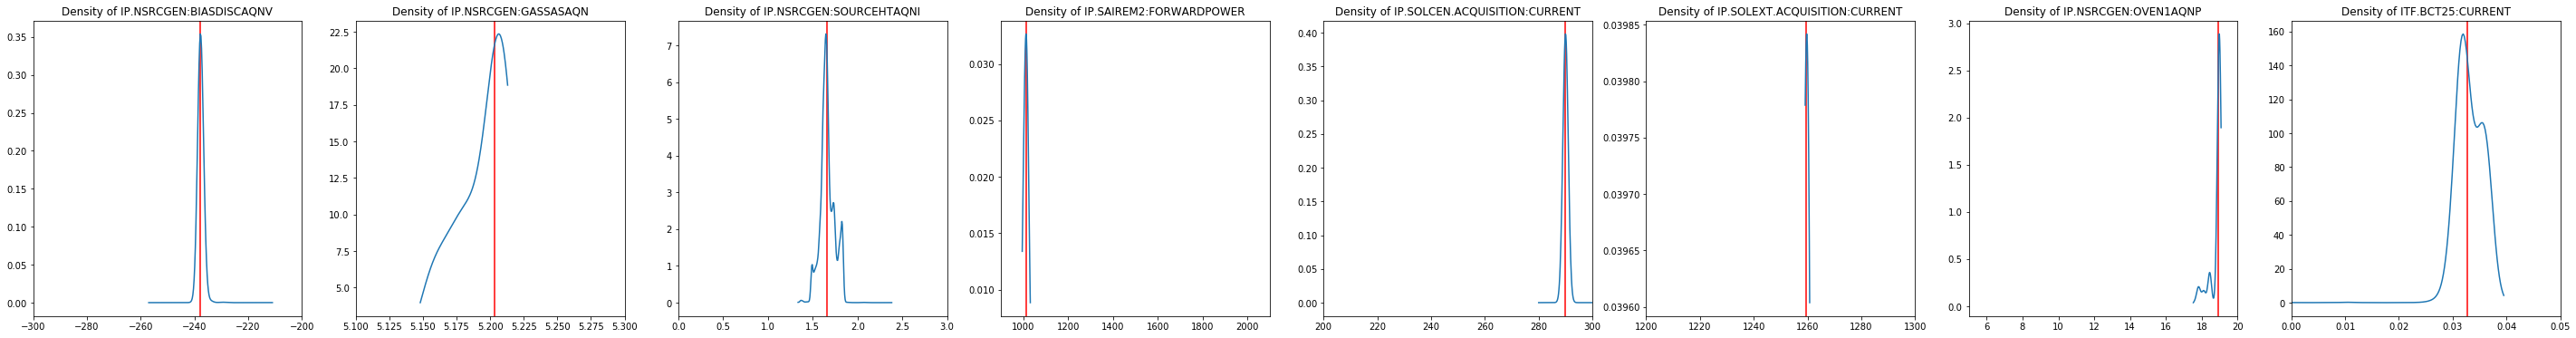

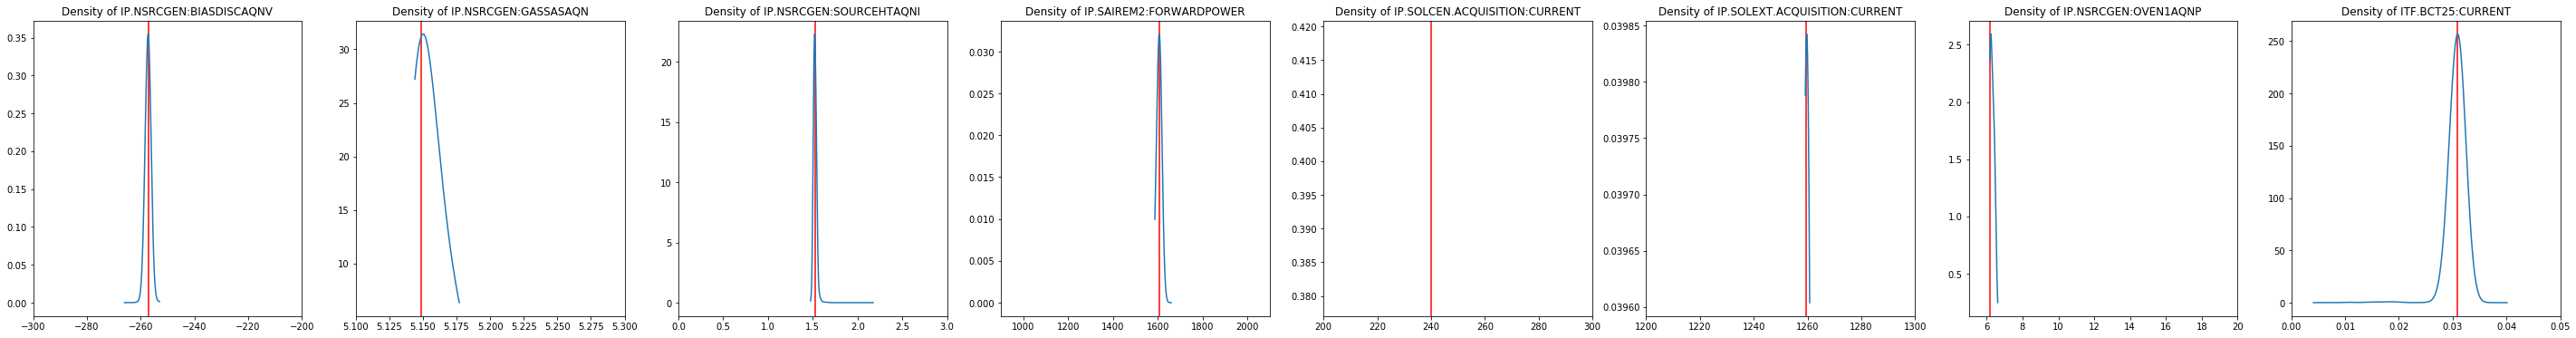

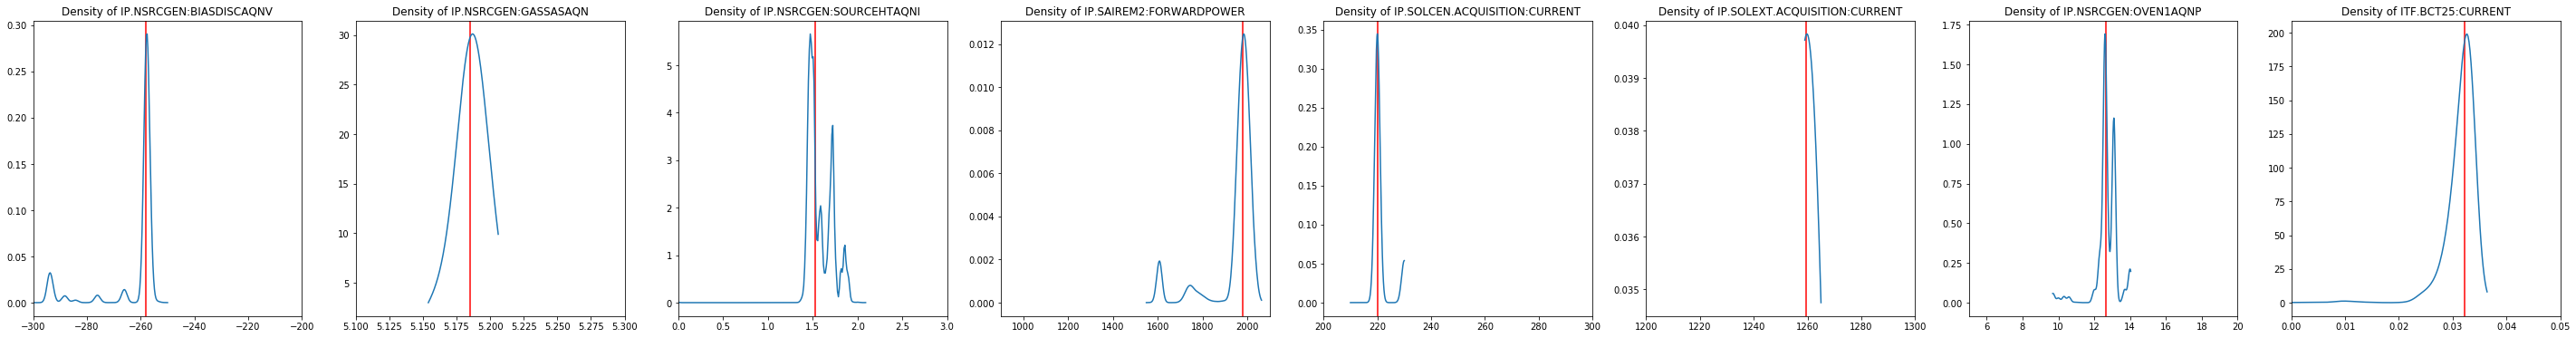

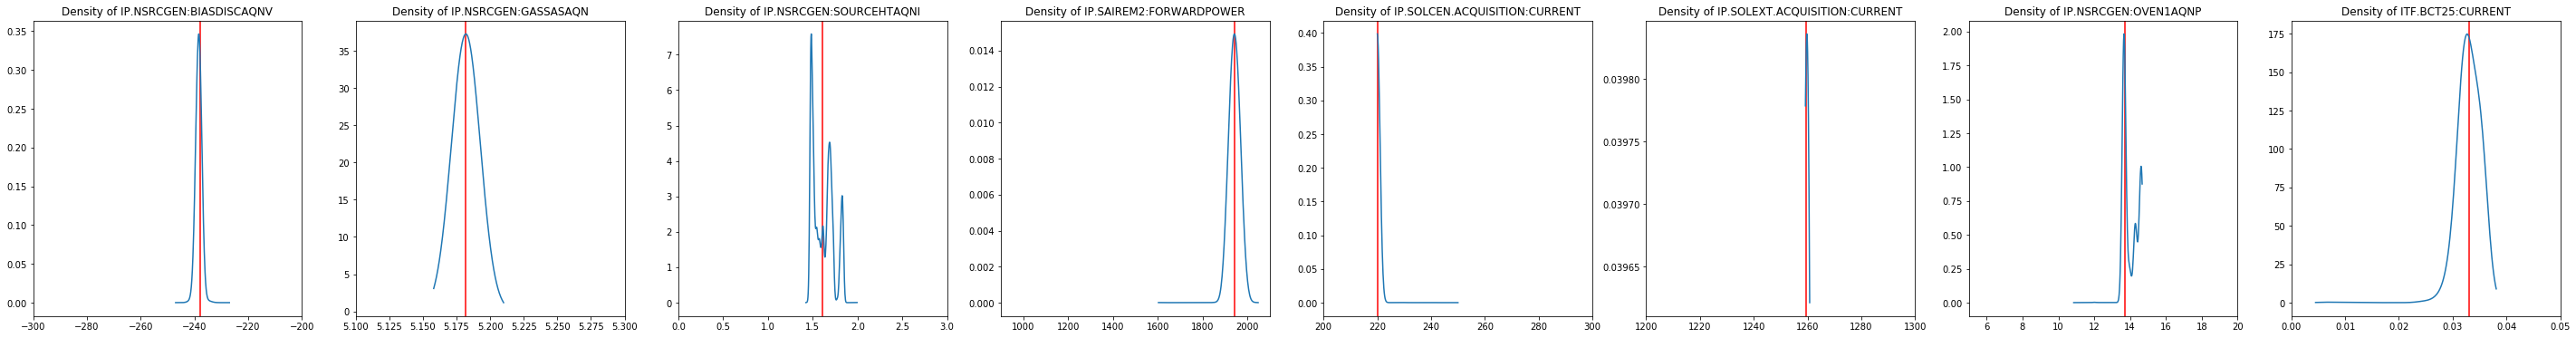

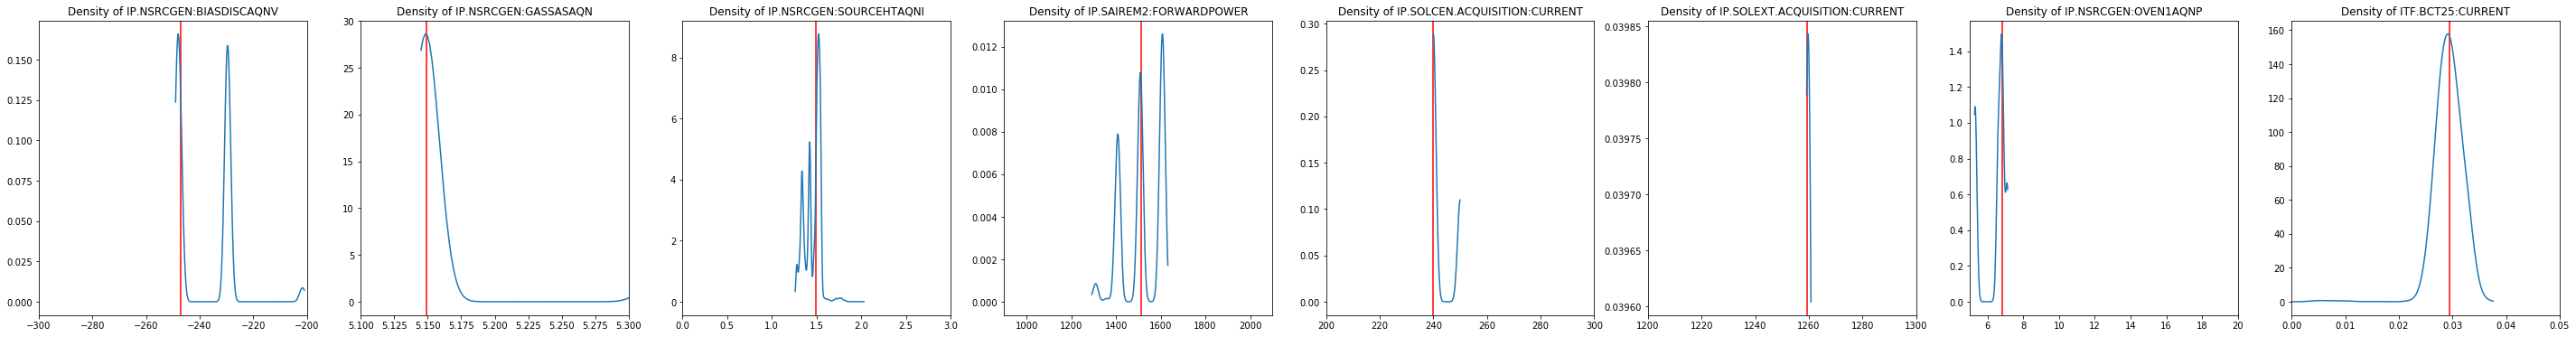

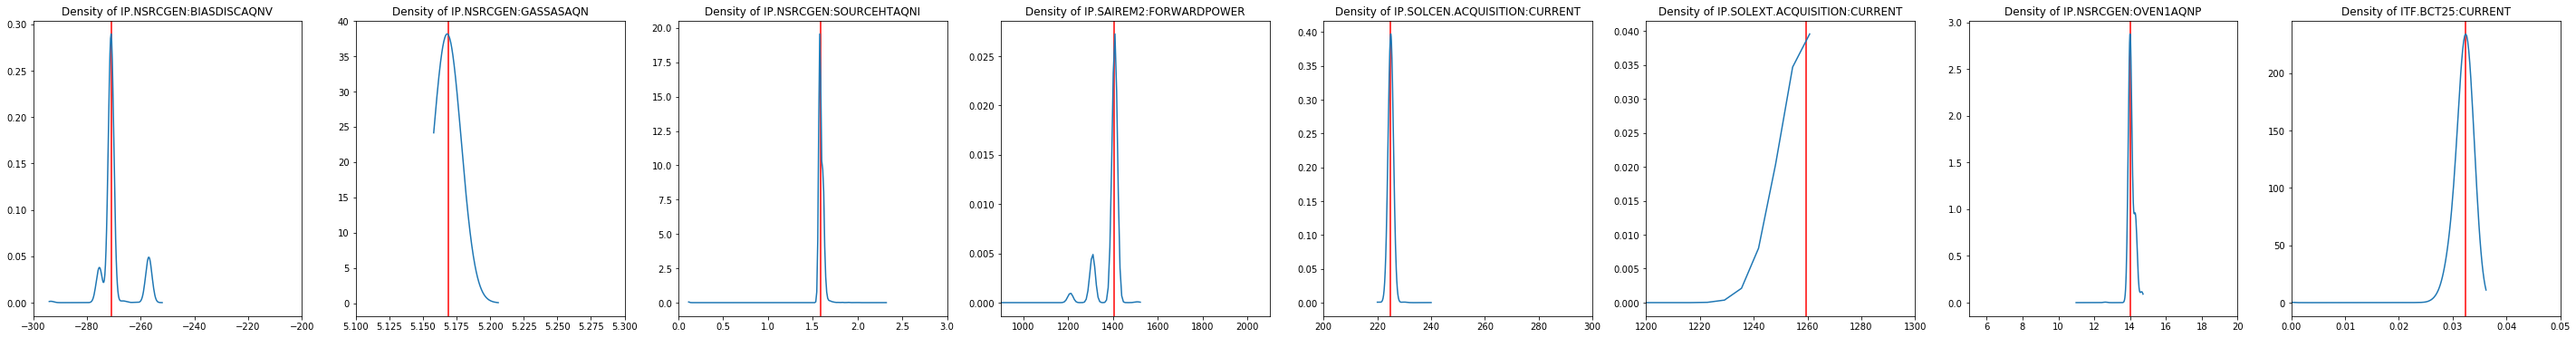

In [67]:
num_clusters = 6 # number of clusters to visualize
data = df[parameters].values # We select the unscaled data again, because by clustering we did not change any ordering and this data corresponds to the real world
num_datapoints = len(data)

resolution = 200
bandwidth = [1, 0.01, 0.01, 10, 1, 10, 0.1, 0.001]
num_kde_samples = 40000

parameter_ranges = [[0,0] for i in range(len(parameters))]
parameter_ranges[0] = [-300, -200] # Biasdisc x-axis

parameter_ranges[1] = [5.1, 5.3] # Gas x-axis
parameter_ranges[2] = [0, 3] # High voltage current x-axis
parameter_ranges[3] = [900, 2100] # Forwardpower x-axis
parameter_ranges[4] = [200, 300] # SolCen current x-axis
parameter_ranges[5] = [1200, 1300] # SolExt current x-axis
parameter_ranges[6] = [5, 20] # Oven1 power x-axis
parameter_ranges[7] = [0, 0.05] # BCT25 current x-axis

opt.sort(key=lambda x: len(x), reverse=True)
for i, cluster in enumerate(opt[:num_clusters]):
    median = [described.iloc[i,described.columns.get_loc((param, '50%'))] for param in parameters]
    plot_cluster(data, cluster, parameters, parameter_ranges, resolution=resolution, median=median, bandwidth=bandwidth, percentage_of_values=1, num_kde_samples=num_kde_samples)